In [6]:
import numpy as np
import skimage as sk
import skimage.io as skio
import glob
from skimage.transform import resize
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import random
import math

In [7]:
def get_faces():
    """
    Face data are X
    Facial Keypoints are y
    """
    asf_files = glob.glob("imm_face_db/*.asf")
    img_files = [s[:-3] + 'jpg' for s in asf_files]
    
    keypoints = []

    for asf in asf_files:
        file = open(asf)
        
        points = file.readlines()[16:74]
        landmark = []

        for point in points:
            x,y = point.split('\t')[2:4]
            landmark.append([float(x), float(y)])
        landmark = np.array(landmark).flatten()
        keypoints.append(np.array(landmark).astype('float32'))
        
    keypoints = np.array(keypoints)

    faces = []

    for img_name in img_files:
        img = skio.imread(img_name)
        img = (img.astype(np.float32) / 255 - 0.5)
        img = resize(img, (180, 240), anti_aliasing=True)
        img = np.mean(img, axis = 2)
        faces.append(img)
        
    faces = np.array(faces)
    
    return faces, keypoints

In [8]:
BATCH_SIZE = 1
NUM_OF_EPOCHS = 25

In [9]:
class FacesDataset(Dataset):
    """Wrapper for Facial Keypoint Dataset"""

    def __init__(self, X, y, augment=False):
        
        assert len(X) == len(y)
                       
        self.faces = torch.Tensor(X).unsqueeze(1)  
        self.keypoints = torch.Tensor(y)
        
        self.augment = augment
        
        if augment:
            self.jitter = transforms.ColorJitter(brightness = .5, contrast=.5, saturation=.5, hue=.2)
            
                  
    def __len__(self):
        return len(self.keypoints)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_keypoint_map = {'image': self.faces[idx], 'keypoints': self.keypoints[idx]}

        if self.augment:
            image_keypoint_map = self.augment_transform(image_keypoint_map)

        return image_keypoint_map
    
    def augment_transform(self, image_keypoint_map):
        image, keypoints = image_keypoint_map['image'], image_keypoint_map['keypoints']
        
        # color jitter chance
        if random.random() > 0.5:
            print("Color Jittered")
            image = self.jitter(image)
        
        #rotation jitter chance
        if random.random() > 0.5:
            print("Rotation Jittered")
            angle = random.randint(-30, 30)
            
            #rotate image
            image = transforms.functional.rotate(image, angle)
            theta = torch.tensor(-angle * math.pi / 180)
            cos, sin = torch.cos(theta), torch.sin(theta)
            
            # create rotation matrix
            rot = torch.stack([torch.stack([cos, sin]),
                   torch.stack([-sin, cos])])
            
            keypoints2d = torch.reshape(keypoints, (58, 2))
            keypoints2d_rot = keypoints2d @ rot
            keypoints = torch.flatten(keypoints2d_rot)
            
        return {'image': image, 'keypoints': keypoints}  

In [10]:
X_all, y_all = get_faces()
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=48, random_state=None, shuffle = False)
train_dataset = FacesDataset(X_train, y_train, augment=True)
val_dataset = FacesDataset(X_val, y_val)

In [11]:
y_all.shape

(240, 116)

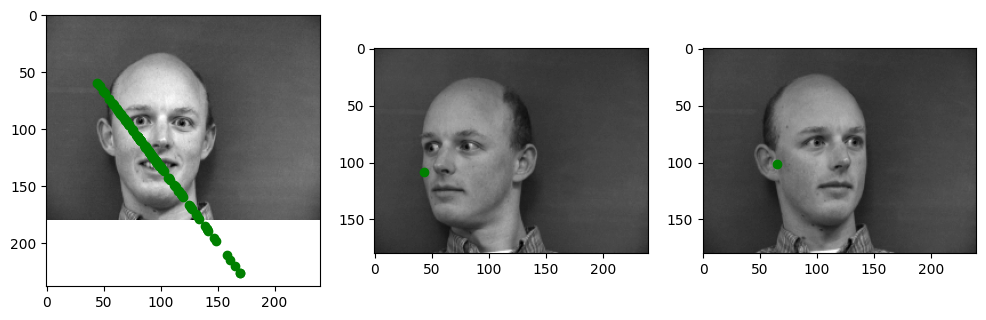

In [12]:
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    total_loss = 0
    
    for i, batch in enumerate(dataloader):
        image, keypoint = batch['image'], batch['keypoints']
        image, keypoint = image.to(device), keypoint.to(device)
        
        # Zero your gradients for every batch!
        model.zero_grad()
        # Make predictions for this batch
        output = model(image)
        loss = loss_function(output, keypoint)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        
    mean_loss = total_loss / (i + 1)
        
    return mean_loss

def validate(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model.eval()
    
    total_loss = 0
    
    for i, batch in enumerate(dataloader):
        image, keypoint = batch['image'], batch['keypoints']
        image, keypoint = image.to(device), keypoint.to(device)
        
        # Zero your gradients for every batch!
        model.zero_grad()
        # Make predictions for this batch
        output = model(image)
        loss = loss_function(output, keypoint)
        
        total_loss += loss
        
    mean_loss = total_loss / (i + 1)
        
    return mean_loss

def predict(dataloader, model):
    
    outputs = []
    model.eval()
    for batch in dataloader:
        image = batch['image']
        image = image.to(device)
        output = model(image)
        output = output.cpu()
        outputs.append(output.detach().numpy())
    
    all_outputs = np.stack(outputs, axis=0)
    return all_outputs

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [39]:
def show_cropped_image_with_points_data_thing(X, y):
    if not isinstance(X, np.ndarray):
        X = X.cpu().detach().numpy()
    
    if not isinstance(y, np.ndarray):
        y = y.cpu().detach().numpy()
    
    X = X.transpose((1, 2, 0))
    
    y = y.reshape((58, 2))
    
    fig = plt.figure(figsize=(8, 10))
    
    ax = fig.subplots()
    ax.imshow(X, cmap="gray")

    ax.scatter(*zip(*(y * np.array([240,180]))))

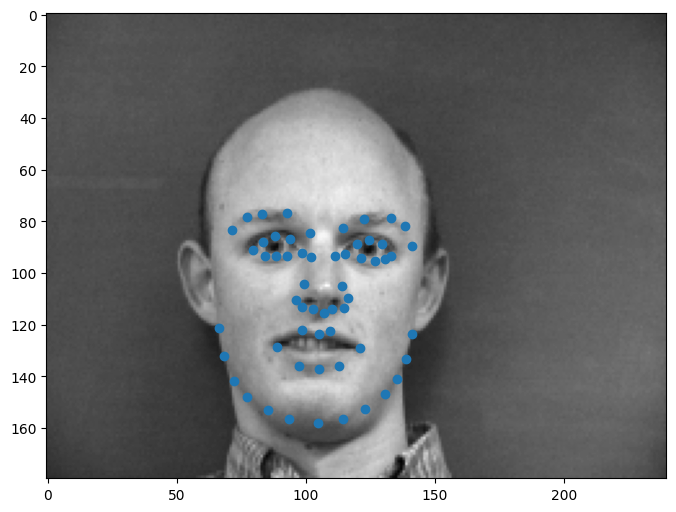

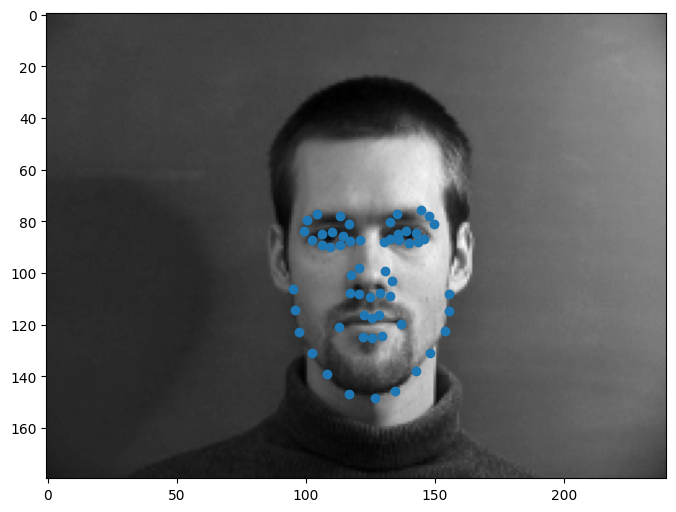

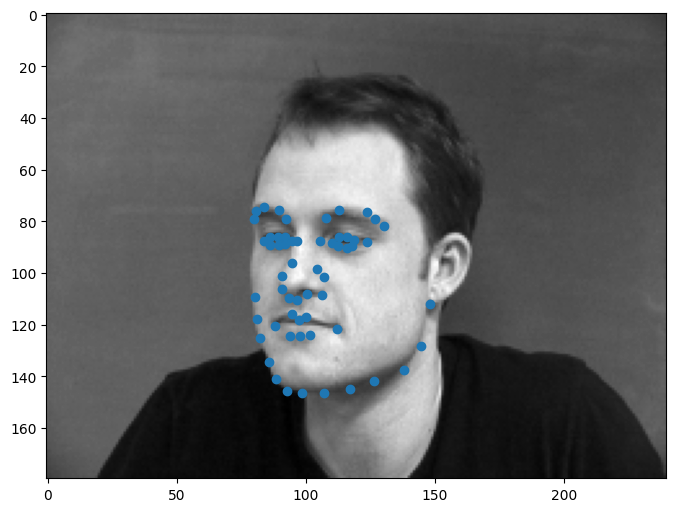

In [44]:
show_cropped_image_with_points_data_thing(*val_dataset[0].values())
plt.savefig("facial_ground_truth1.jpg")
show_cropped_image_with_points_data_thing(*val_dataset[10].values())
plt.savefig("facial_ground_truth2.jpg")
show_cropped_image_with_points_data_thing(*val_dataset[20].values())
plt.savefig("facial_ground_truth3.jpg")


# Neural Net

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [17]:
class FaceNet(nn.Module):
    def __init__(self):
        super(FaceNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        
#         # kernel
#         self.conv1 = nn.Conv2d(1, 6, 8)
#         self.conv2 = nn.Conv2d(6, 16, 8)
#         self.conv3 = nn.Conv2d(16, 22, 8)
#         self.conv4 = nn.Conv2d(22, 28, 8)
#         self.conv5 = nn.Conv2d(28, 34, 8)
        
        self.conv1 = nn.Conv2d(1, 12, 8)
        self.conv2 = nn.Conv2d(12, 12, 8)
        self.conv3 = nn.Conv2d(12, 12, 8)
        self.conv4 = nn.Conv2d(12, 12, 8)
        self.conv5 = nn.Conv2d(12, 12, 8)
        
        # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(9282, 500)  # 5*5 from image dimension
#         self.fc2 = nn.Linear(500, 116)
        self.fc1 = nn.Linear(3276, 500)  # 5*5 from image dimension
        self.fc2 = nn.Linear(500, 116)
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
model = FaceNet().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
print(model)

FaceNet(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv4): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv5): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=3276, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=116, bias=True)
)


In [19]:
train_losses = []
val_losses = []

for epoch in range(NUM_OF_EPOCHS):
    train_loss = train(train_loader, model, loss_function, optimizer)
    val_loss = validate(val_loader, model, loss_function, optimizer)
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    print("finished epoch: ", epoch)

Rotation Jittered
Color Jittered
Color Jittered
Rotation Jittered
Rotation Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Rotation Jittered
Rotation Jittered
Rotation Jittered
Rotation Jittered
Rotation Jittered
Rotation Jittered
Color Jittered
Color Jittered
Rotation Jittered
Color Jittered
Color Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Rotation Jittered
Color Jittered
Color Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Rotation Jittered
Rotation Jittered
Color Jittered
Rotation Jittered
Rotation Jittered
Rotation Jittered
Color Jittered
Color Jittered
Rotation Jittered
Color Jittered
Color Jittered
Rotation Jittered
Color Jittered
Color Jittered
Color Jittered
Rotation Jittered
Rotation Jittere

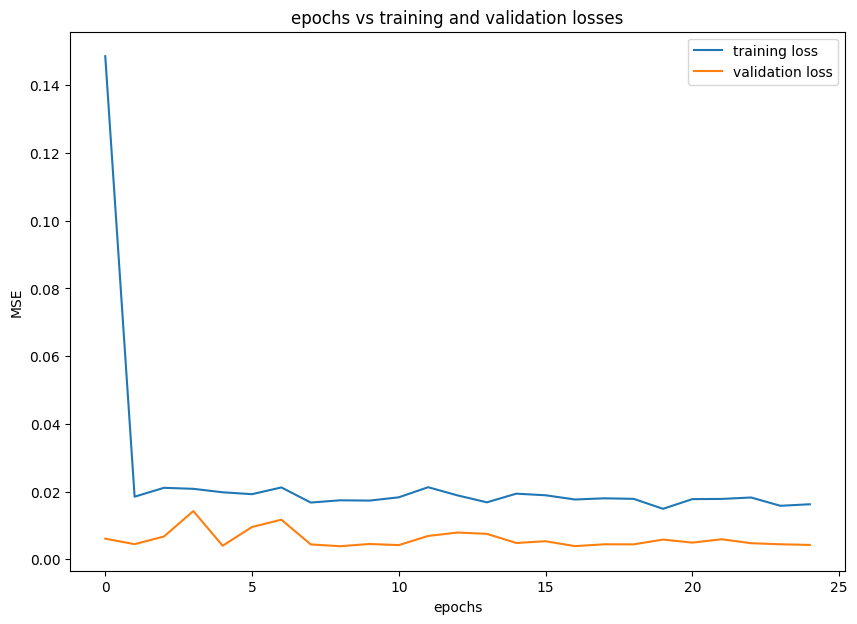

In [20]:
plt.figure(figsize = (10, 7))
plt.plot(range(len(train_losses)), train_losses, label = 'training loss')
plt.plot(range(len(val_losses)), val_losses, label = 'validation loss')
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.title('epochs vs training and validation losses')
plt.legend()
plt.savefig("epoch_vs_training_facial_keypoints.jpg")

In [21]:
predictions = predict(val_loader, model)
predictions = predictions.reshape((predictions.shape[0], predictions.shape[-1]))
rankings = list(np.arange(len(predictions)))
rankings.sort(key=lambda i: sum((predictions[i] - y_val[i])**2))
rankings[:5]

[24, 12, 0, 16, 31]

In [22]:
def show_image_and_points(ax, image_idx):
    ax.set_title(f"validation set number {image_idx}")
    ax.imshow(X_val[image_idx], cmap='gray')
    pred_point = predictions[image_idx] 
    pred_point = pred_point.reshape((58,2))* np.array([240, 180])
    
    gt_point = y_val[image_idx]
    gt_point = gt_point.reshape((58,2))* np.array([240, 180])
    
    ax.scatter(gt_point[:,0], gt_point[:,1], color='blue', label='ground truth')
    ax.scatter(pred_point[:,0], pred_point[:,1], marker='x', color='orange',label = 'prediction')
    ax.legend()

# Best Facial features

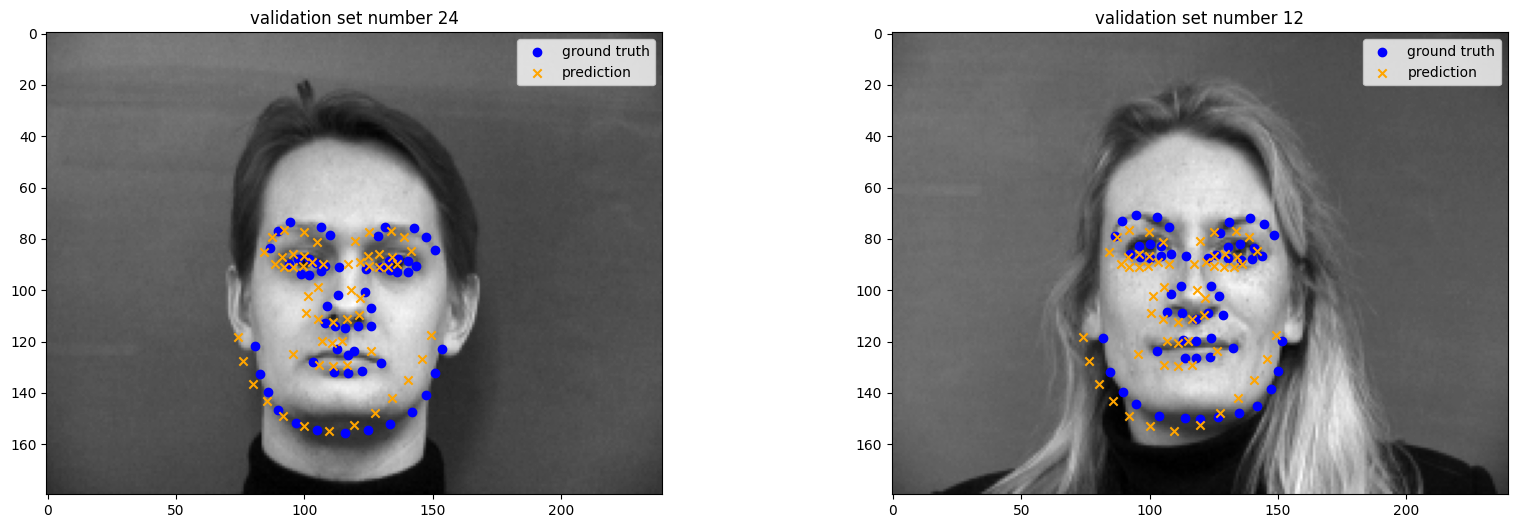

In [23]:
fig = plt.figure(figsize=(20, 6))
axes = fig.subplots(1, 2)
for ax, idx in list(zip(axes, rankings[:2])):
    show_image_and_points(ax, idx)
plt.savefig("best_facial_keypoints_detection.jpg")

# Worst Facial features

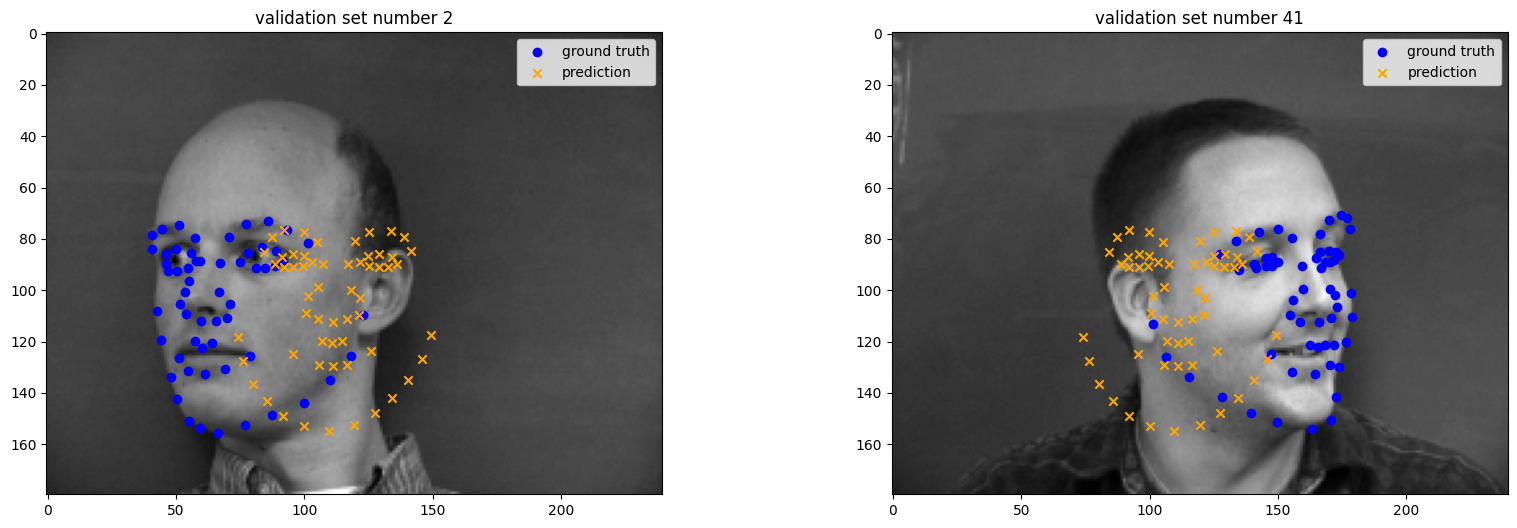

In [24]:
fig = plt.figure(figsize=(20, 6))
axes = fig.subplots(1, 2)
for ax, idx in list(zip(axes, rankings[-2:])):
    show_image_and_points(ax, idx)
plt.savefig("worst_facial_keypoints_detection.jpg")

# Visualizing Filters

In [25]:
def display_grid_of_images(array_of_images, array_of_names, w = 6, h = 5):
    num_rows = len(array_of_images)
    num_cols = len(array_of_images[0])
  
    fig = plt.figure(figsize=(w * num_cols, h * num_rows))
    subplots = fig.subplots(num_rows, num_cols, squeeze = False)
    
    for row in range(num_rows):
        for col in range(num_cols):
            
            ax = subplots[row, col]
            ax.set_title(array_of_names[row][col])
            pixels = array_of_images[row][col]
            
            if len(pixels.shape) == 2:
                ax.imshow(pixels,cmap='Greys_r')
            if len(pixels.shape) == 3:
                ax.imshow(pixels)
    return fig
                
def show_filters(weights):
    rows, cols = weights.shape[0], weights.shape[1]
    titles = [[f"in: {in_c}, out: {out_c}" for in_c in range(cols)] for out_c in range(rows)]
    
    return display_grid_of_images(weights, titles, w = 3, h = 3)

In [26]:
retrieve = lambda x: x.weight.cpu().detach().numpy()
conv1, conv2, conv3 = retrieve(model.conv1), retrieve(model.conv2), retrieve(model.conv3)

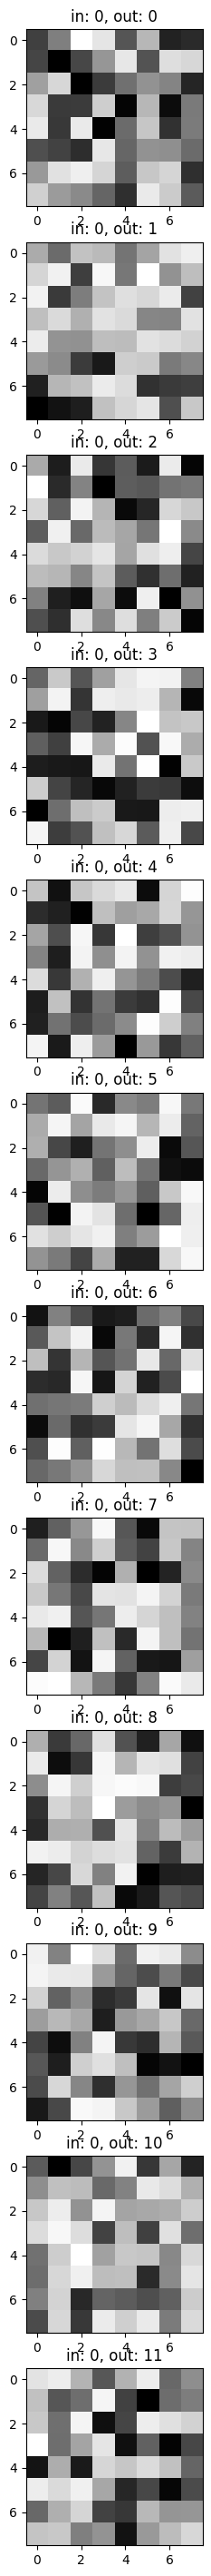

In [27]:
fig = show_filters(conv1)
fig.savefig("face_conv1.jpg")

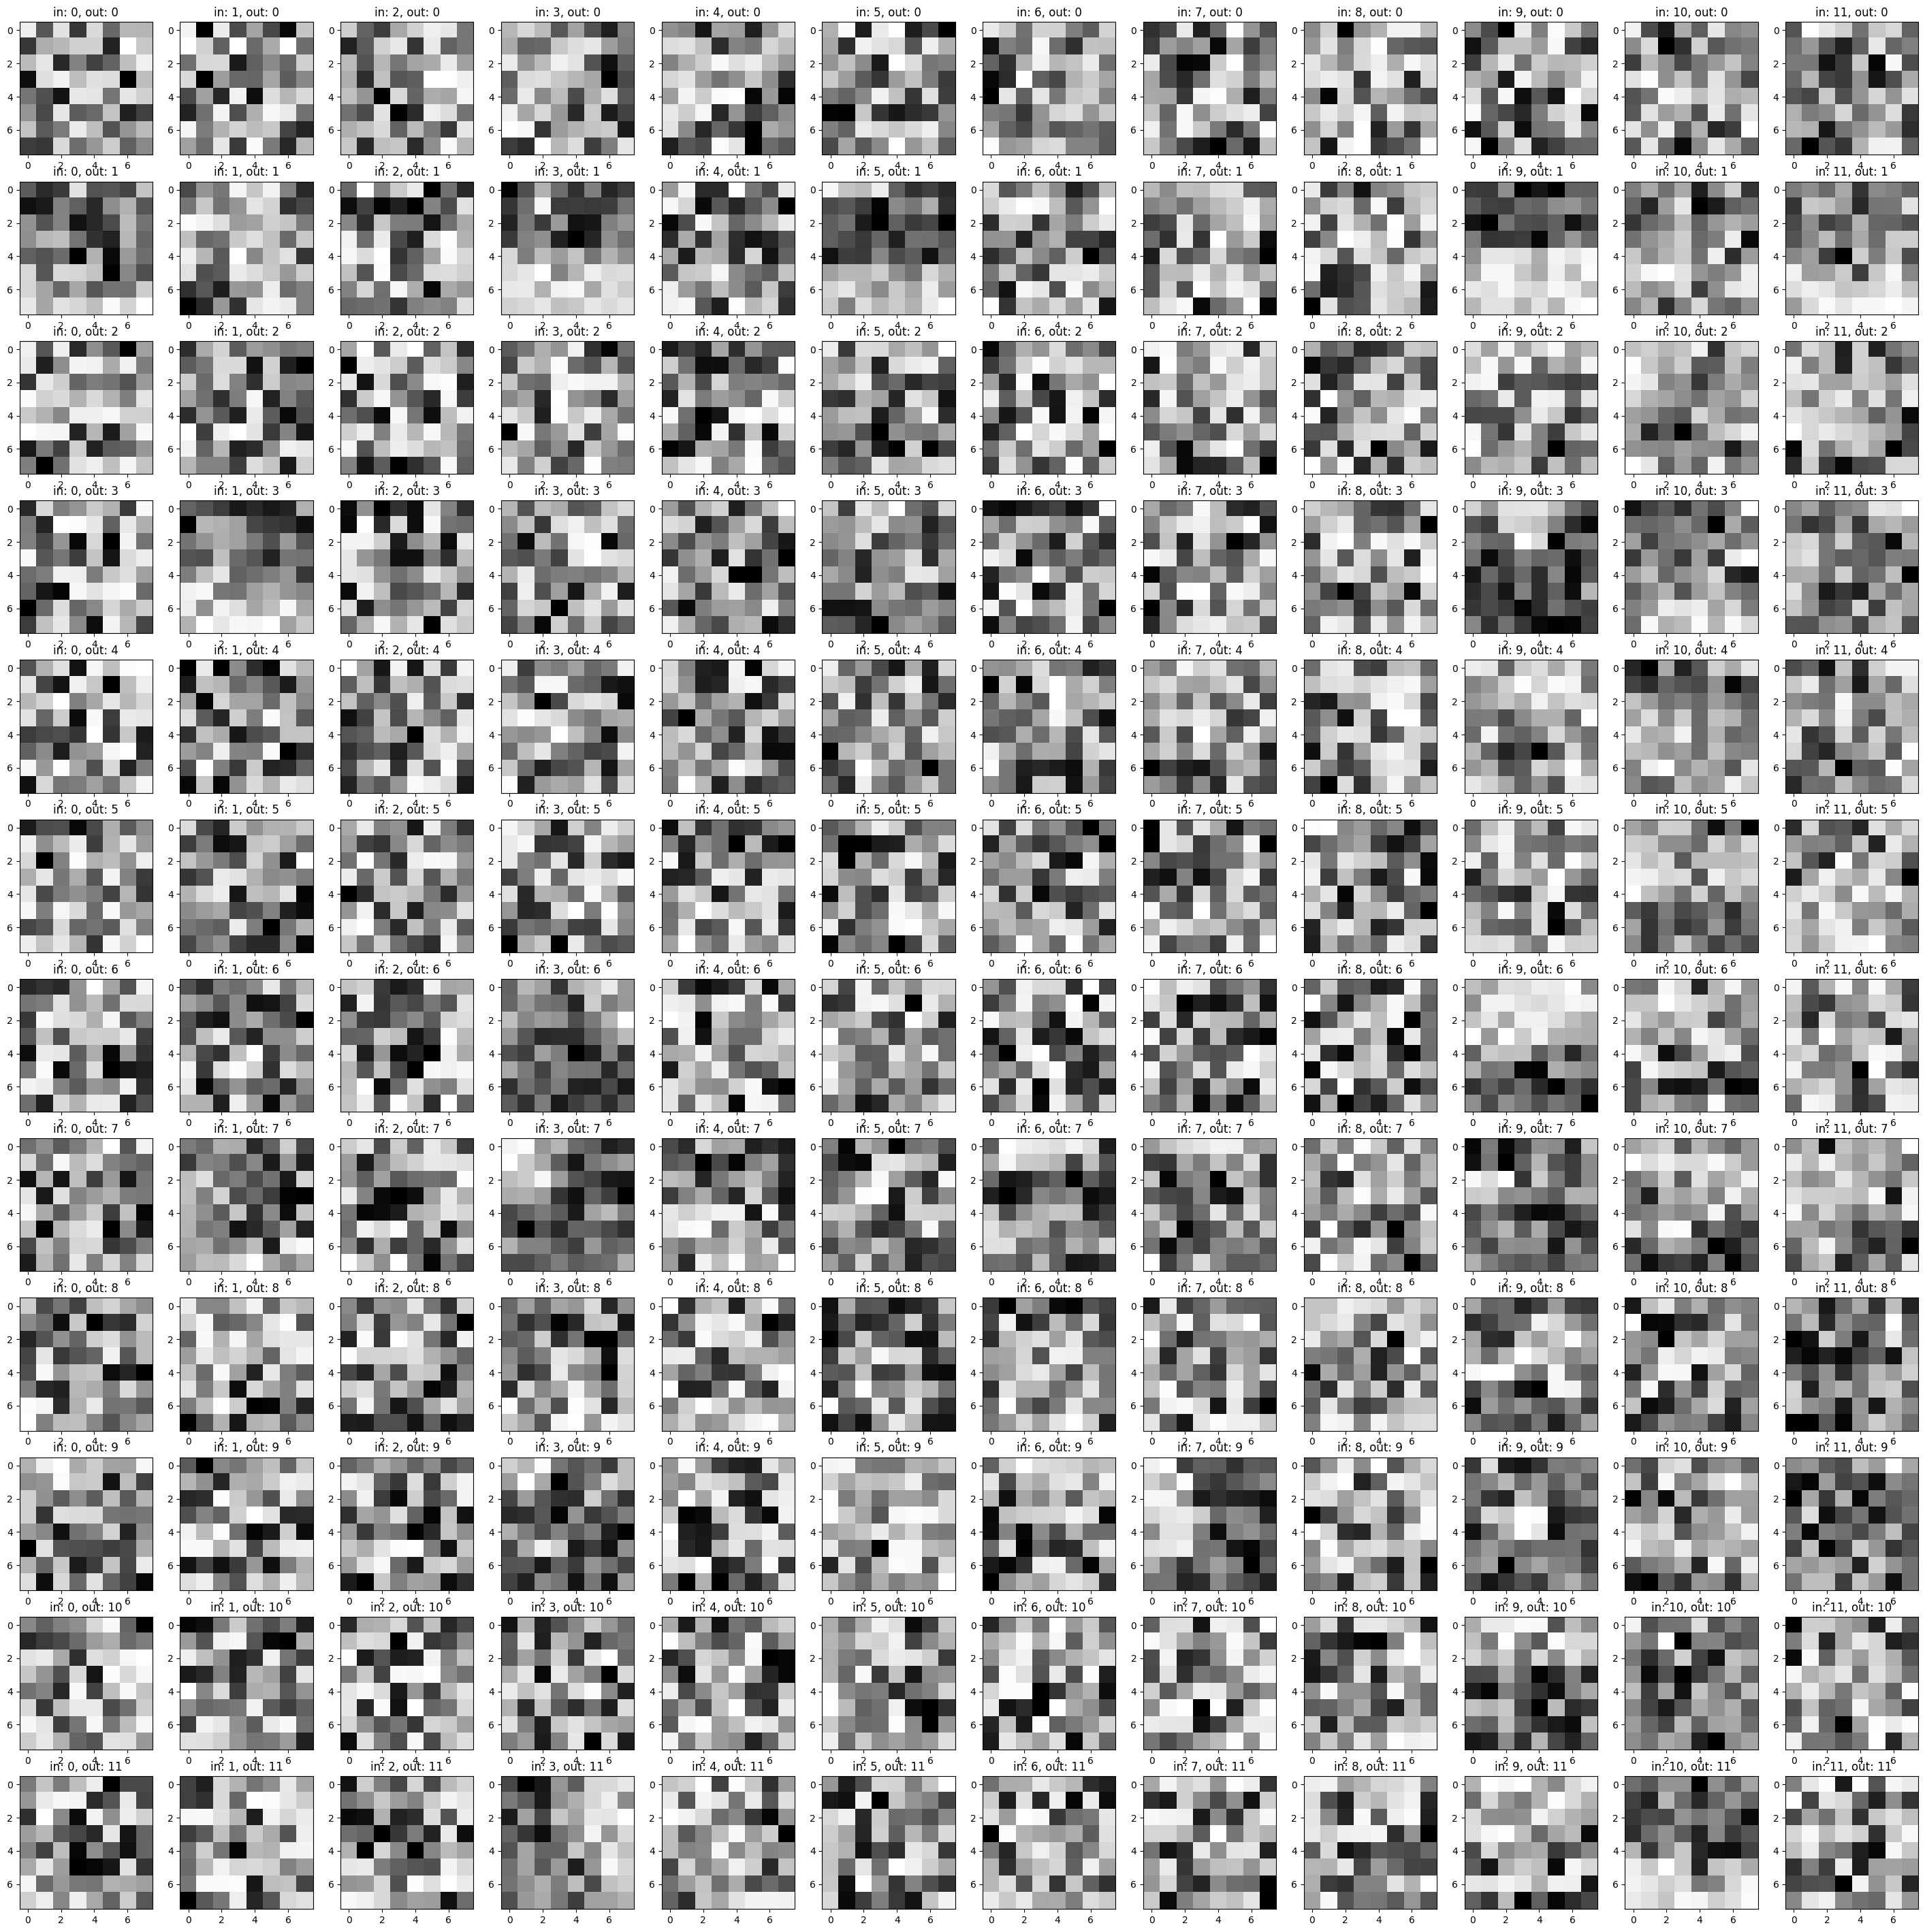

In [28]:
fig = show_filters(conv2)
fig.savefig("face_conv2.jpg")

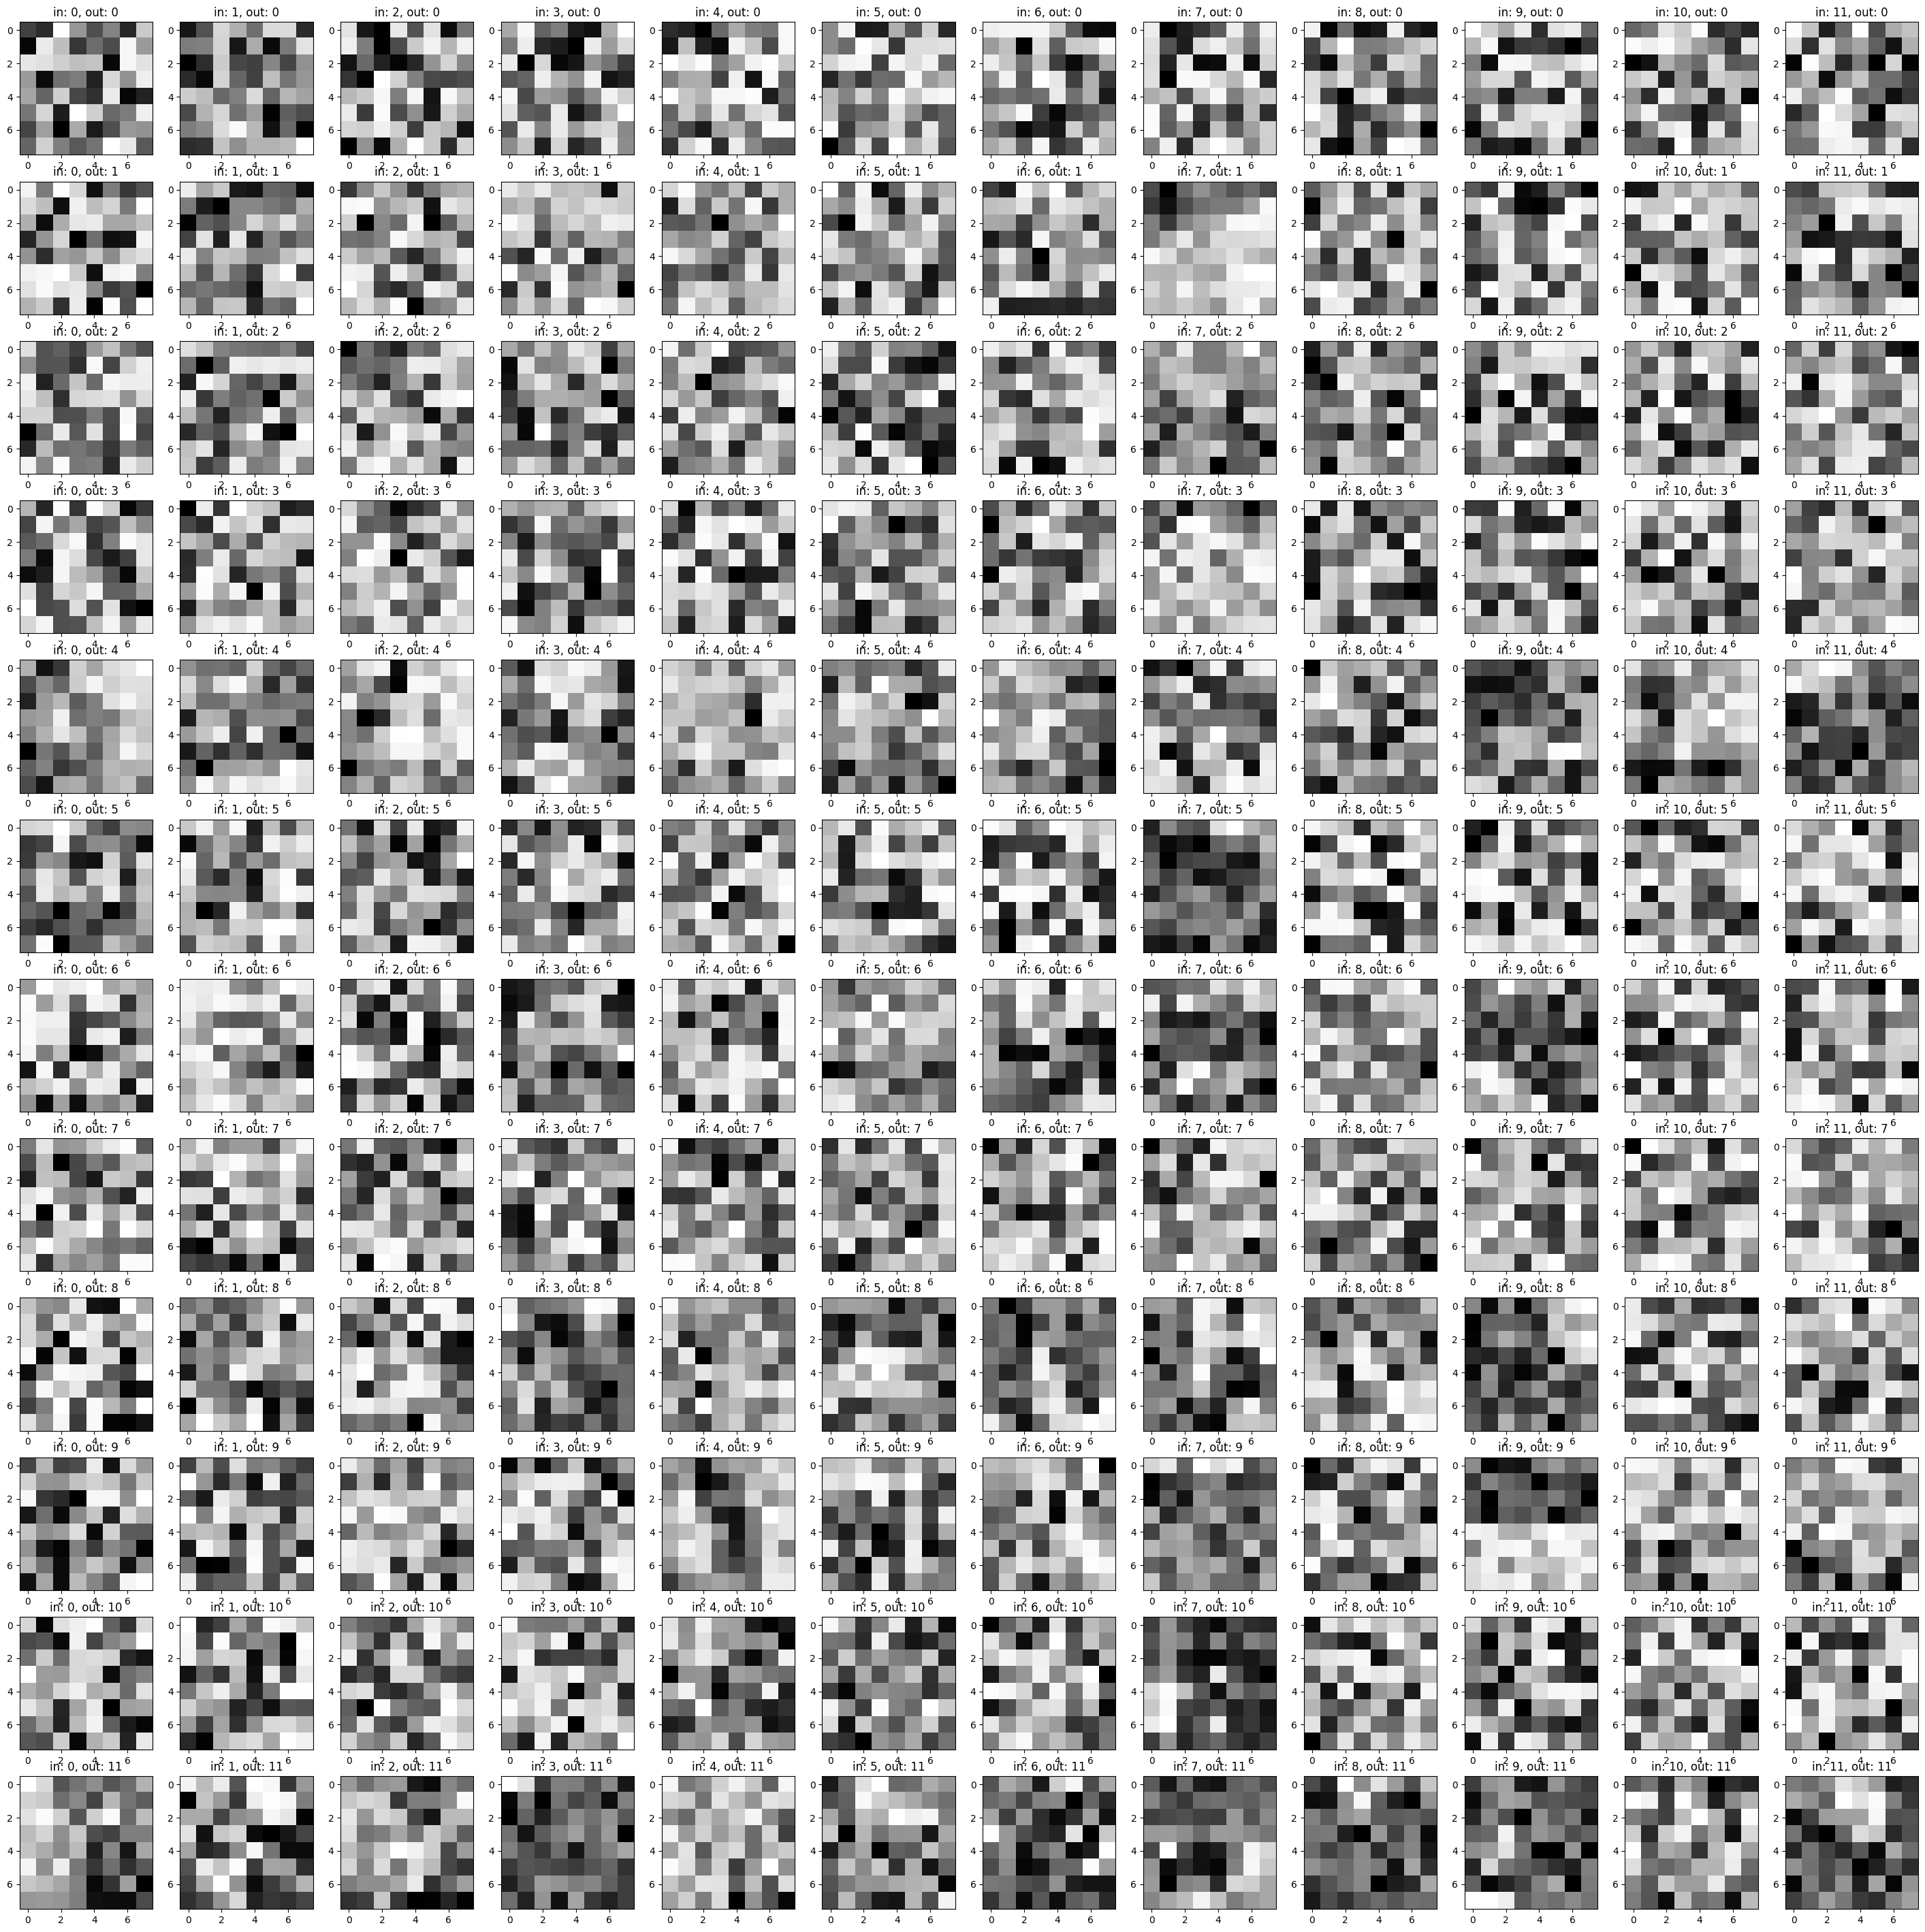

In [29]:
fig = show_filters(conv3)
fig.savefig("face_conv3.jpg")